In [13]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from glob import glob
from os.path import join

plt.style.use(["science", "ieee", "no-latex"])
plt.rcParams["font.family"] = "Georgia"

RESULTS_DIR = "results"
HUE_ORDER = ["Federated", "Centralized", "Decentralized"]
STYLE_ORDER = ["Federated", "Centralized", "Decentralized"]


In [34]:
json_data = {}
filename_template = "{}_{}_*_{}_*.json"
for trainer in ["FedRL", "MARL", "SARL"]:
    for intersection in ["3x3", "5x5", "double"]:
        for ranked in ["ranked", "unranked"]:
            pattern = filename_template.format(trainer, intersection, ranked)
            filename = next(iter(glob(join("..", "out", "experiments", "realworld", ranked, pattern))))
            json_obj = json.load(open(filename, "r"))
            json_data[trainer, intersection, ranked] = json_obj

print(set(json_data.keys()))

{('FedRL', '5x5', 'unranked'), ('FedRL', 'double', 'unranked'), ('MARL', '5x5', 'unranked'), ('FedRL', 'double', 'ranked'), ('SARL', '3x3', 'ranked'), ('MARL', 'double', 'ranked'), ('SARL', '5x5', 'ranked'), ('SARL', '5x5', 'unranked'), ('SARL', '3x3', 'unranked'), ('FedRL', '3x3', 'ranked'), ('MARL', '3x3', 'ranked'), ('FedRL', '5x5', 'ranked'), ('FedRL', '3x3', 'unranked'), ('MARL', '5x5', 'ranked'), ('MARL', '3x3', 'unranked'), ('SARL', 'double', 'unranked'), ('MARL', 'double', 'unranked'), ('SARL', 'double', 'ranked')}


In [35]:
df_data = defaultdict(list)
for (trainer, intersection, ranked), data in json_data.items():
    num_data_items = len(data["reward"])
    for i in range(num_data_items):
        df_data["trainer"].append(trainer)
        df_data["intersection"].append(intersection)
        df_data["ranked"].append(ranked)
        df_data["step"].append(data["step"][i])
        df_data["tls_id"].append(data["tls_id"][i])
        df_data["reward"].append(data["reward"][i])

df = pd.DataFrame.from_dict(df_data)
df["trainer"].replace({
    "FedRL": "Federated",
    "MARL": "Decentralized",
    "SARL": "Centralized"
}, inplace=True)
df["intersection"].replace({
    "3x3": "Grid-3x3",
    "5x5": "Grid-5x5",
    "double": "Double"
}, inplace=True)
df.head()

,trainer,intersection,ranked,step,tls_id,reward
0,Federated,Grid-3x3,ranked,1,0,-2.0
1,Federated,Grid-3x3,ranked,1,1,-1.2
2,Federated,Grid-3x3,ranked,2,0,-2.0
3,Federated,Grid-3x3,ranked,2,1,-1.2
4,Federated,Grid-3x3,ranked,3,0,-2.0


In [36]:
with sns.plotting_context(font_scale=2):
    g = sns.displot(
        data=df,
        kind="ecdf",
        x="reward",
        col="trainer",
        row="ranked",
        # multiple="stack",
        hue="intersection",
        # fill=True,
        # alpha=0.5
        # bw_adjust=.2
    ).set(yscale="log")
    g.axes[0, 0].set_ylabel("CDF Value")
    for col in range(3):
        g.axes[0, col].set_xlabel("Reward")
        g.axes[0, col].grid(linestyle="--")
    sns.despine(top=False, right=False, bottom=False, left=False)
    plt.show()

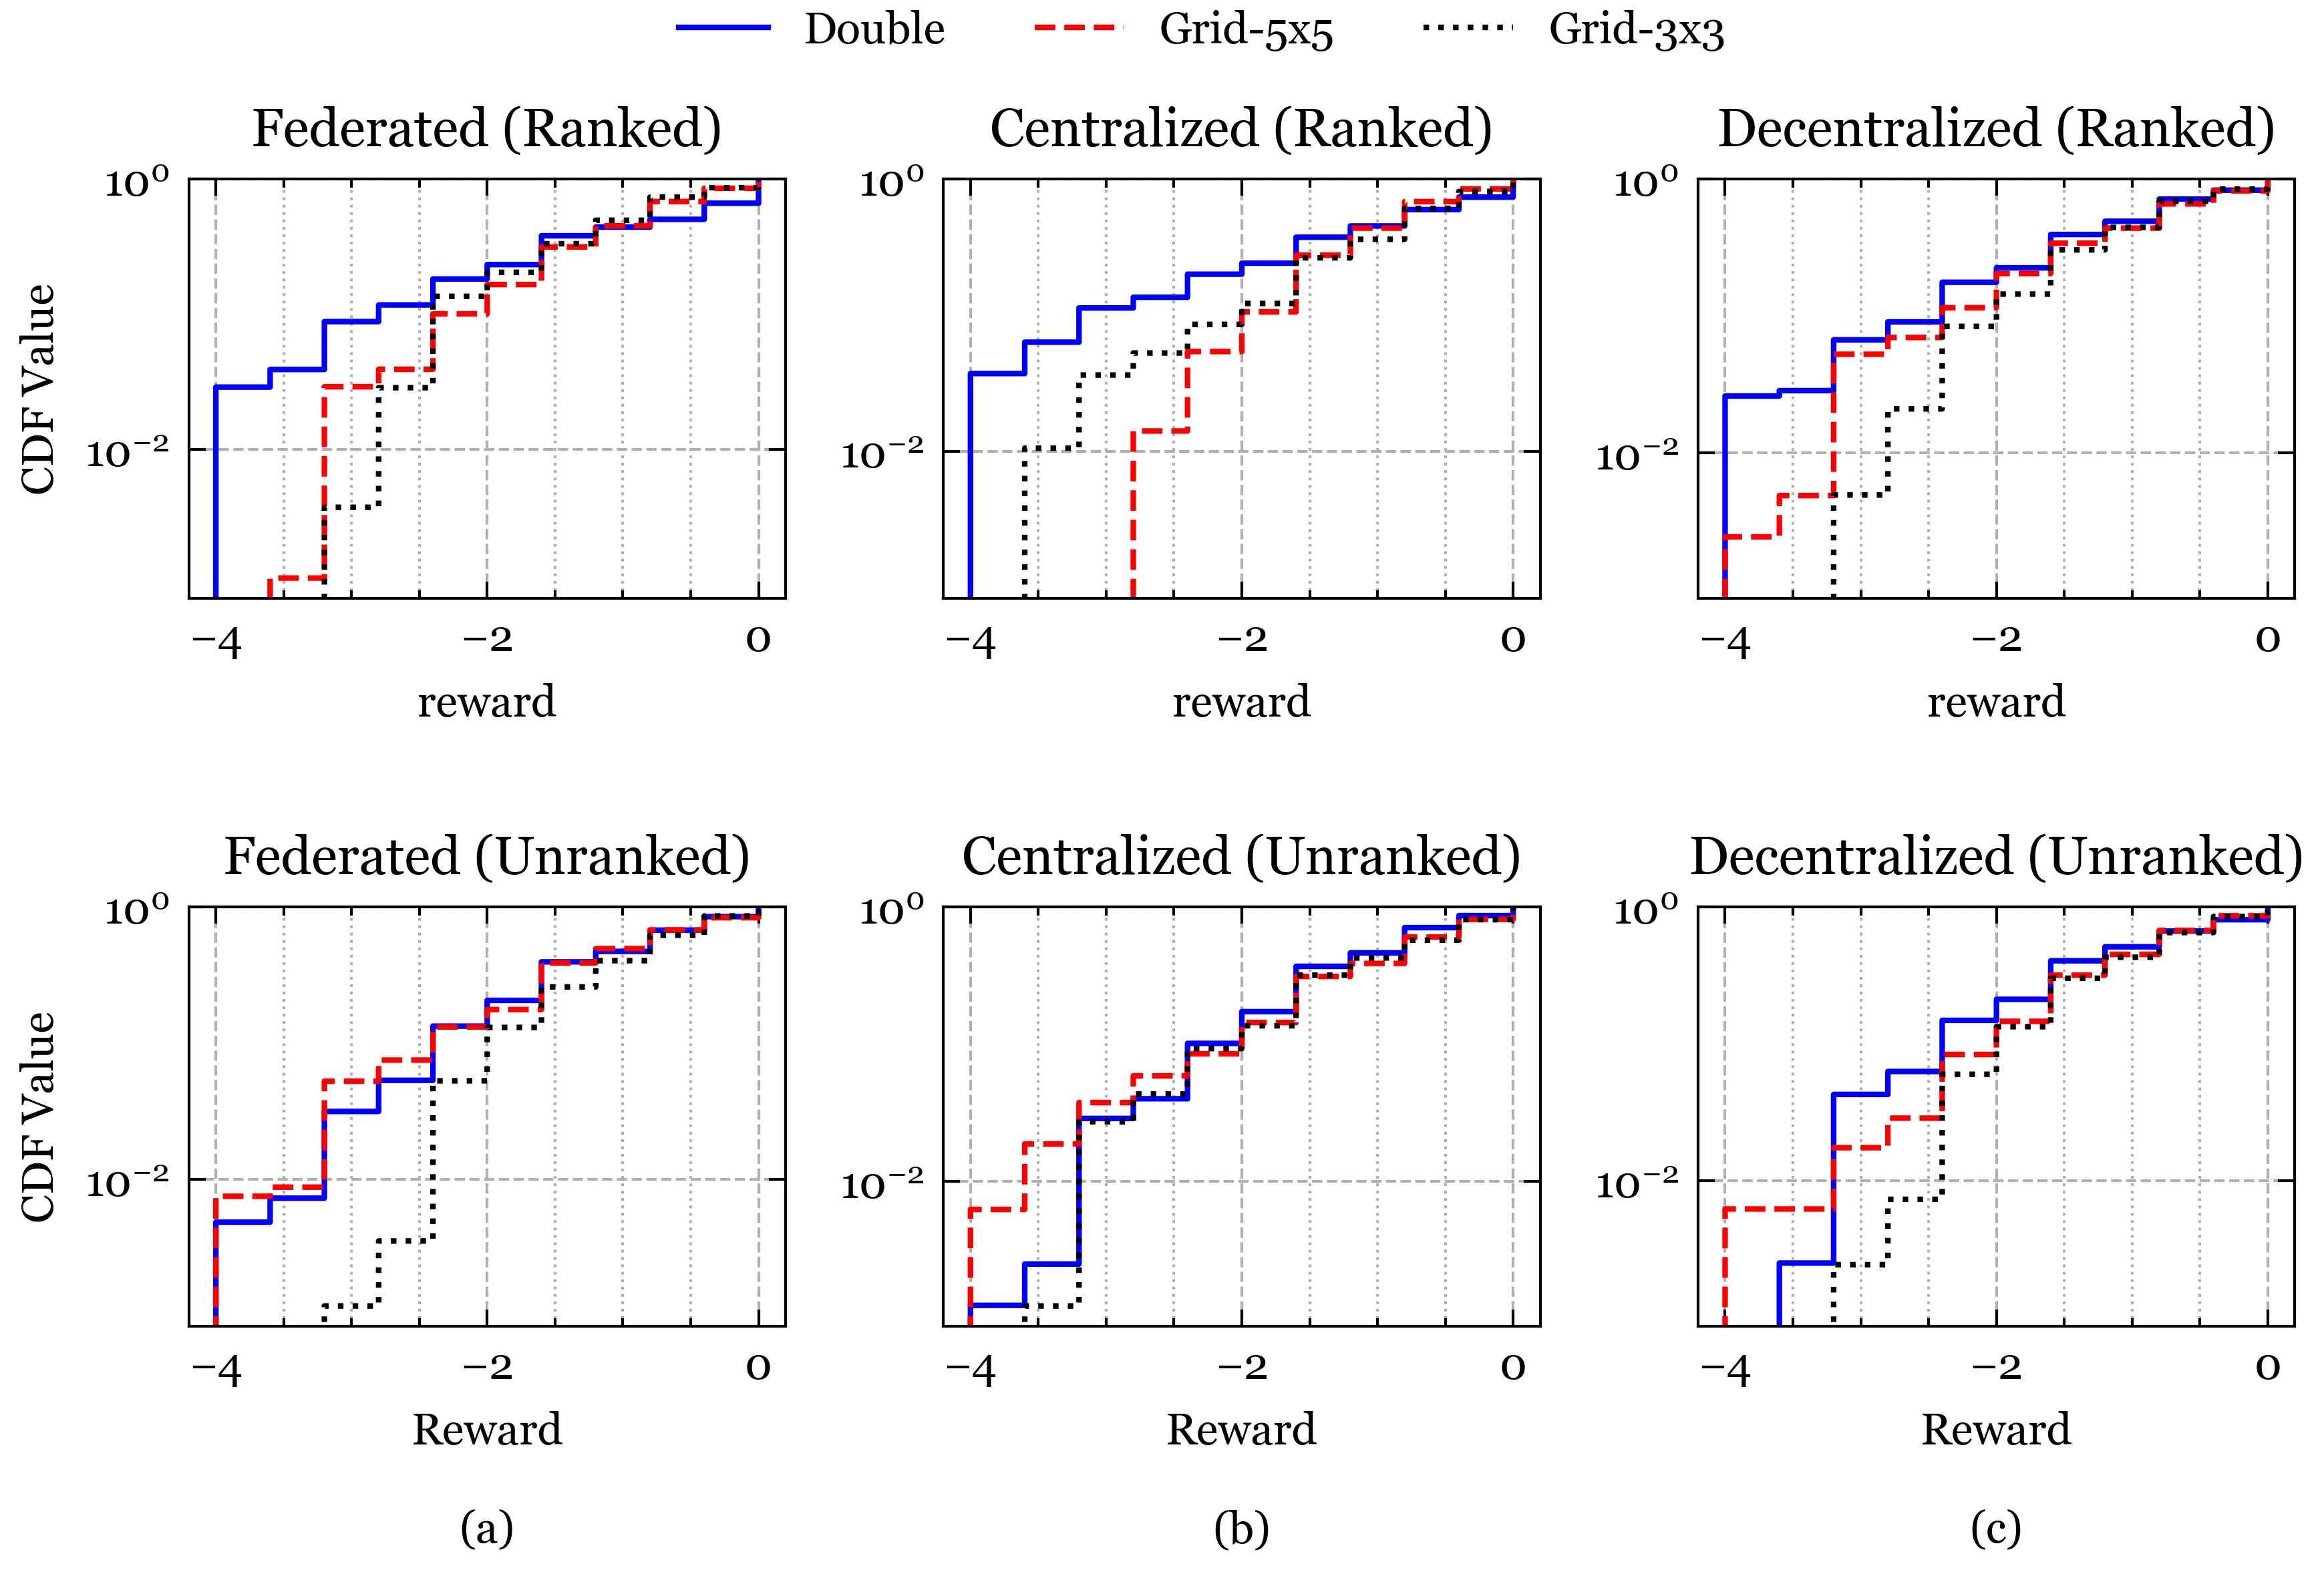

In [47]:
with sns.plotting_context(font_scale=1.15):
    NROWS, NCOLS = 2, 3
    fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6, 4))
    for (row, ranked) in enumerate(['ranked', 'unranked']):
        for (col, trainer) in enumerate(["Federated", "Centralized", "Decentralized"]):
            q = f"trainer == '{trainer}' and ranked == '{ranked}'"
            sns.ecdfplot(
                data=df.query(q),
                x="reward",
                hue="intersection",
                # ax=axes[col],
                ax=axes[row, col]
            ).set(yscale="log")

            axes[row, col].grid(which="major", linestyle="--")
            axes[row, col].grid(which="minor", linestyle=":")
            axes[row, col].set_title(f"\n{trainer} ({ranked.title()})")
            handles, labels = axes[row, col].get_legend_handles_labels()
            axes[row, col].get_legend().remove()
            children = axes[row, col].get_children()

    for row in range(NROWS):
        for col in range(1, NCOLS):
            axes[row, col].set_ylabel("")

    for label, col in zip(["a", "b", "c"], range(NCOLS)):
        axes[1, col].set_xlabel(f"Reward\n\n({label})")

    for row in range(NROWS):
        axes[row, 0].set_ylabel("CDF Value")

    # fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    # fig.suptitle("Weighted Total Communication Cost\n")
    handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
    labels = ["Double", "Grid-5x5", "Grid-3x3"]
    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center",
               bbox_to_anchor=(0.5, 1.0))
    # fig.suptitle("Real-World Reward Distribution\n\n\n ")
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "real-world_reward_ecdf.pdf"))
    plt.show()


In [ ]:
df["reward"].unique()

array([-2. , -1.2, -0. , -1.6, -0.8, -0.4])